## Model Inspection

#### Imports

In [1]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.api import keras

from hpcscripts.sharedutils.trainingutils import LoadModel, SetLowTFVerbose, MakeSinglePrediction, CreateWindowGenerator
from hpcscripts.sharedutils.nomalization import DF_Nomalize, denorm
from hpcscripts.sharedutils.modelutils import SelectModelPrompt
from hpcscripts.option import pathhandler as ph
from hpcscripts.option import globalparams as G_PARAMS

2022-06-23 19:51:36.432172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 19:51:36.480111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-06-23 19:51:36.480136: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-23 19:51:36.480758: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

### Function Definitions

In [2]:
# Get Training Data to calculate norm param
train_file = os.path.join(ph.GetProcessedPath("Combined"), "Train_set.csv")
train_data, NORM_PARAM = DF_Nomalize(pd.read_csv(train_file))

# Make TensorFlow Quiet
SetLowTFVerbose()

# rad2deg
rad2deg = 180 / math.pi

labels = G_PARAMS.SEQUENTIAL_LABELS

In [3]:
def get_file_list():
    train_dir = ph.GetProcessedPath("Selected")
    test_dir  = ph.GetProcessedPath("Test")

    train_list = os.listdir(train_dir)
    test_list  = os.listdir(test_dir)

    for i, test_file in enumerate (test_list):
        train_list.remove(test_file)
        test_list[i] = os.path.join(test_dir, test_file)

    for i, train_file in enumerate (train_list):
        train_list[i] = os.path.join(train_dir, train_file)

    print ("Files found: ")
    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    # Slicing
    print ("\nAfter Slicing: ")
    # train_list = train_list[:3]
    # test_list  = test_list[:3]

    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    return train_list, test_list

In [4]:
def Predict(filename: str, model, window, NORM_PARAM=NORM_PARAM):
    prediction_dict = {}
    file_path = os.path.join (ph.GetProcessedPath("Test"), filename)

    test_df, predictions = MakeSinglePrediction(file_path, model, window)

    for i, label in enumerate(labels):
        z, s = NORM_PARAM[label]
        zt,st= NORM_PARAM["time_s"]

        denormed_time  = denorm(test_df["time_s"].to_numpy(), zt, st)
        denormed_label = denorm(test_df[label], z, s)
        denormed_pred  = denorm(predictions[:, i], z, s)

        if (label.endswith("rad")):
            denormed_pred = denormed_pred * rad2deg
            denormed_label= denormed_label* rad2deg

        prediction_dict[label] = (denormed_label, denormed_pred)
    
    return denormed_time, prediction_dict

def ShowPrediction(filename: str, model, window, NORM_PARAM=NORM_PARAM,
                win_start: int=0, win_end: int=-1
):
    denormed_time, prediction_dict = Predict(filename, model, window, NORM_PARAM)

    for i, label in enumerate(labels):
        denormed_label, denormed_pred = prediction_dict[label]

        # plt.plot(denormed_time[win_start:win_end], denormed_label[win_start:win_end])
        plt.scatter(denormed_time[win_start:win_end], denormed_label[win_start:win_end], c='r', marker='X')
        plt.scatter(denormed_time[win_start:win_end], denormed_pred[win_start:win_end], c='b', marker='*')

        print ("timespan: {}".format(denormed_time[-1] - denormed_time[0]))
        print ("mae: {}".format(keras.metrics.mean_absolute_error(denormed_label, denormed_pred)))

        plt.legend(["real", "prediction"])
        plt.xlabel(label.removesuffix("rad")+"deg" if label.endswith("rad") else label)
        plt.show()

def ShowComparison(filename: str, model, window, NORM_PARAM=NORM_PARAM,
                win_start: int=0, win_end: int=-1
):
    denormed_time, prediction_dict = Predict(filename, model, window, NORM_PARAM)

    for i, label in enumerate(labels):
        denormed_label, denormed_pred = prediction_dict[label]

        label_min = float (denormed_label[win_start:win_end].min())
        label_max = float (denormed_label[win_start:win_end].max())
        eq_line = np.linspace(label_min, label_max, denormed_label[win_start:win_end].shape[0])

        # plt.plot(denormed_time[win_start:win_end], denormed_label[win_start:win_end])
        plt.scatter(denormed_label[win_start:win_end], denormed_pred[win_start:win_end], c='r', marker='X')
        plt.plot(eq_line, eq_line)

        print ("timespan: {}".format(denormed_time[-1] - denormed_time[0]))
        print ("mae: {}".format(keras.metrics.mean_absolute_error(denormed_label, denormed_pred)))

        plt.legend(["real", "prediction"])
        plt.xlabel(label.removesuffix("rad")+"deg" if label.endswith("rad") else label)
        plt.show()

## Importing Model

In [5]:
model_dir = ph.GetModelsPath()
model_dir = SelectModelPrompt(model_dir)

print ()
model, model_history, modelsmeta = LoadModel(model_dir)

G_PARAMS.SetParams(modelsmeta['param'])

epochs = [a+1 for a in range(len(model_history['loss']))]
print ("\nmodel_id: {}".format(modelsmeta['model_id']))
print ("model_history keys: {}".format(model_history.keys()))
print ("modelsmeta: {}".format(modelsmeta))

Found 18 models inside /home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Models:
index    Model-name
  [0].   ANN 2022-06-22 02:12:29
  [1].   ANN 2022-06-22 02:17:25
  [2].   ANN 2022-06-23 17:05:03
  [3].   ANN 2022-06-23 17:13:06
  [4].   ANN 2022-06-23 17:19:12
  [5].   ANN 2022-06-23 17:28:53
  [6].   ANN 2022-06-23 17:32:38
  [7].   ANN 2022-06-23 17:37:34
  [8].   ANN 2022-06-23 17:40:25
  [9].   ANN 2022-06-23 17:44:35
  [10].  ANN 2022-06-23 17:50:31
  [11].  ANN 2022-06-23 17:59:31
  [12].  ANN 2022-06-23 18:03:45
  [13].  ANN 2022-06-23 18:07:20
  [14].  ANN 2022-06-23 18:25:26
  [15].  ANN 2022-06-23 18:31:40
  [16].  ANN 2022-06-23 18:36:39
  [17].  ANN 2022-06-23 18:40:53
You selected model ANN 2022-06-23 18:40:53


model loaded
model history loaded
model metadata loaded

model_id: wrap_hidden
model_history keys: dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])
modelsmeta: {'model_id': 'wra

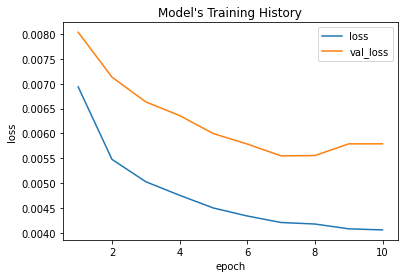

In [6]:
metric = 'loss'
plt.plot(epochs, model_history[metric])
plt.plot(epochs, model_history['val_{}'.format(metric)])

plt.xlabel("epoch")
plt.ylabel(metric)
plt.title("Model's Training History")
plt.legend(['loss', 'val_{}'.format(metric)])
plt.show()

In [7]:
_z, _s = NORM_PARAM['elv_l_rad']
last_val_MAE = model_history['val_mean_absolute_error'][-1]

print ("denormed MAE: {}".format(denorm(last_val_MAE, _z, _s)))
print ("denormed MAE: {}".format(denorm(0.0000, _z, _s)))

elv_MAE = denorm(last_val_MAE, _z, _s)-denorm(0.0000, _z, _s)
elv_MAE = elv_MAE*180/math.pi 
print ("MAE: {} deg".format(elv_MAE))


denormed MAE: -0.0791588209418878
denormed MAE: -0.08058942777347788
MAE: 0.08196773359269506 deg


## Making Few Predictions

In [8]:
train_list, test_list = get_file_list()

pred_window = CreateWindowGenerator(
                    train_list=test_list,
                    test_list=None, eval_list=None,
                    norm_param=NORM_PARAM
                )

Files found: 
	Train count: 352
	Test count : 61

After Slicing: 
	Train count: 352
	Test count : 61


In [9]:
filename = test_list[0]
os.path.basename(filename)

'flight_28936.csv'

timespan: 194.0
mae: 0.23710258305072784


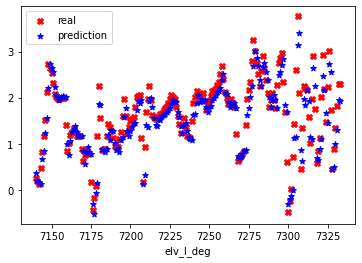

timespan: 194.0
mae: 0.32048019766807556


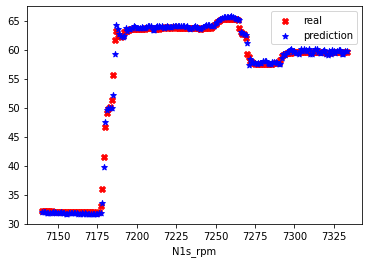

COMPARISON
timespan: 194.0
mae: 0.23710258305072784


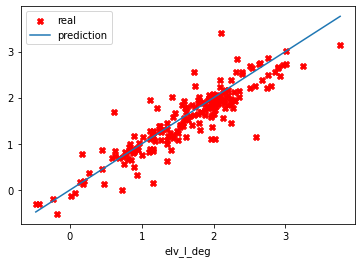

timespan: 194.0
mae: 0.32048019766807556


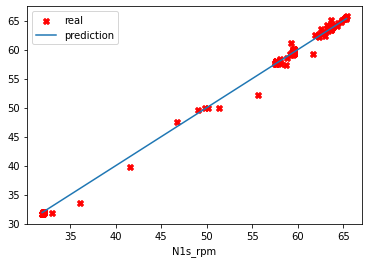

In [22]:
_flightname = "flight_22498.csv" # "flight_14196.csv"
_win_start = 0#150
_win_end = -1 #200

ShowPrediction( 
            _flightname,# "flight_10301.csv",
            model=model,
            window=pred_window,
            win_start=_win_start,
            win_end=_win_end
        )

print ("COMPARISON")
ShowComparison( 
            _flightname,# "flight_10301.csv",
            model=model,
            window=pred_window,
            win_start=_win_start,
            win_end=_win_end
        )

## R2 Results

In [11]:
# Check r2 results
r2csv_path = os.path.join(model_dir, "r2.csv")
if not os.path.exists(r2csv_path):
    exit()

r2_df = pd.read_csv(r2csv_path)

r2_df.describe()
#r2_df.head()

,r2_elv_l_rad,mae_elv_l_rad,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,0.955089,0.002067,0.000011,0.997324,0.239292,0.196445
std,0.041513,0.000722,0.000008,0.002662,0.060876,0.095910
min,0.792199,0.000918,0.000002,0.985894,0.153623,0.064732
25%,0.955647,0.001473,0.000005,0.997294,0.195935,0.137978
50%,0.966769,0.002075,0.000009,0.998164,0.229347,0.180420
75%,0.979752,0.002469,0.000013,0.998792,0.265940,0.226398
max,0.990359,0.004321,0.000050,0.999415,0.424244,0.497741


In [12]:
r2_df.nlargest(8, columns=["r2_elv_l_rad"])

,filename,r2_elv_l_rad,mae_elv_l_rad,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
7,flight_14196.csv,0.990359,0.000918,0.000002,0.994764,0.281438,0.321242
44,flight_17553.csv,0.987696,0.001138,0.000002,0.998405,0.176332,0.135575
17,flight_21072.csv,0.987413,0.001215,0.000004,0.999258,0.195935,0.093373
4,flight_14365.csv,0.987007,0.001147,0.000004,0.998164,0.211738,0.154009
8,flight_15502.csv,0.985835,0.001390,0.000004,0.999225,0.240819,0.121047
20,flight_31632.csv,0.985779,0.002117,0.000010,0.996084,0.249075,0.269580
35,flight_13485.csv,0.985101,0.001379,0.000005,0.998792,0.259525,0.196534
2,flight_39113.csv,0.984468,0.001642,0.000006,0.999239,0.220395,0.078026


In [13]:
# r2_df.loc[r2_df.iloc[:, 1] < 0]
r2_df.nsmallest(10, columns=["r2_elv_l_rad"])

,filename,r2_elv_l_rad,mae_elv_l_rad,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
55,flight_22498.csv,0.792199,0.004138,0.000034,0.998095,0.320480,0.276883
19,flight_40945.csv,0.809193,0.002957,0.000024,0.994062,0.400457,0.408302
14,flight_11823.csv,0.828768,0.003251,0.000027,0.998468,0.154783,0.093676
53,flight_39880.csv,0.844390,0.004321,0.000050,0.998194,0.327137,0.259915
23,flight_18297.csv,0.892522,0.002658,0.000017,0.995062,0.231681,0.202193
51,flight_29640.csv,0.910045,0.002641,0.000017,0.998444,0.325471,0.222815
10,flight_21884.csv,0.926991,0.002325,0.000009,0.995821,0.337988,0.280772
25,flight_32637.csv,0.929036,0.002456,0.000016,0.999387,0.210648,0.095282
6,flight_40083.csv,0.931793,0.003292,0.000022,0.998389,0.229797,0.218001
32,flight_35322.csv,0.933813,0.002502,0.000013,0.993727,0.403084,0.497741


filename: flight_33369.csv
timespan: 251.0
mae: 0.0843898206949234


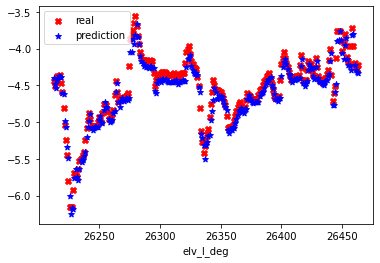

timespan: 251.0
mae: 0.15740565955638885


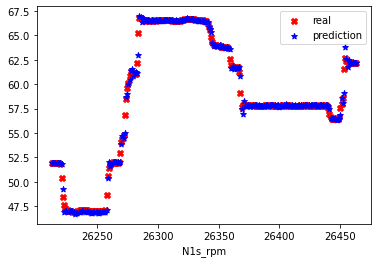

In [14]:
filename_to_predict = "flight_33369.csv"
print ("filename: {}".format(filename_to_predict))
ShowPrediction(filename_to_predict, model, window=pred_window)

#### .Timespan

min: 201.0
max: 428.0
avg: 316.8196721311475


(array([3., 0., 0., 0., 0., 3., 1., 2., 4., 3., 5., 1., 1., 1., 3., 2., 7.,
        2., 2., 3., 1., 4., 5., 2., 0., 2., 3., 0., 0., 1.]),
 array([201.        , 208.56666667, 216.13333333, 223.7       ,
        231.26666667, 238.83333333, 246.4       , 253.96666667,
        261.53333333, 269.1       , 276.66666667, 284.23333333,
        291.8       , 299.36666667, 306.93333333, 314.5       ,
        322.06666667, 329.63333333, 337.2       , 344.76666667,
        352.33333333, 359.9       , 367.46666667, 375.03333333,
        382.6       , 390.16666667, 397.73333333, 405.3       ,
        412.86666667, 420.43333333, 428.        ]),
 <BarContainer object of 30 artists>)

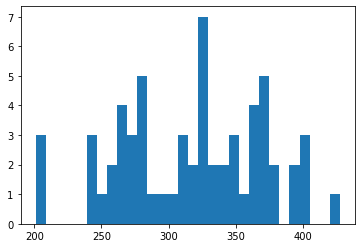

In [15]:
timespans = []
test_dir = ph.GetProcessedPath("Test")
dir_list = os.listdir(test_dir)
for filename in dir_list:
    filepath = os.path.join(test_dir, filename)
    _df = pd.read_csv(filepath)

    timespans.append(_df.loc[_df.shape[0]-1,"time_s"] - _df.loc[0,"time_s"])

print("min: {}".format(min(timespans)))
print("max: {}".format(max(timespans)))
print("avg: {}".format(np.mean(timespans)))

plt.hist(timespans, 30)

In [16]:
bellow_200 = []
for timespan in timespans:
    if timespan < 200:
        bellow_200.append(timespan)

len(bellow_200)

0

### Make Predictions

#### Func Definition

In [17]:
def PlotManyPredictions(filelist, r: int = 2):
    fig = plt.figure(constrained_layout=True)

    label_count = len(G_PARAMS.SEQUENTIAL_LABELS)
    rows = r
    cols = 4

    gs = fig.add_gridspec(rows*label_count, cols)

    i = 0
    for j in range(cols):
        for i in range(rows):
            flightname = filelist[i*cols + j]
            denormed_time, prediction_dict = Predict(
                                                filename=flightname,
                                                model=model,
                                                window=pred_window,
                                                NORM_PARAM=NORM_PARAM
                                            )

            # Plot every labels for one flight
            for sr in range(label_count):
                label_index = sr
                label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

                denormed_label, denormed_pred = prediction_dict[label]

                ax = fig.add_subplot(gs[i*label_count + sr, j])
                ax.plot (denormed_time, denormed_label)
                ax.plot (denormed_time, denormed_pred)
                ax.grid()

                if label_index == 0:
                    ax.set_title(flightname)
                if label_index == label_count-1:
                    ax.set_xlabel("Time (s)")

                if j == 0 or j == 2:
                    ax.set_ylabel('\n'*j + label)
                if j == 1 or j == 3:
                    ax.legend(["real", "prediction"])

    fig.set_size_inches(18/4*cols, 3*rows)
    fig.suptitle("Prediction Samples\n")
    fig.show()

In [18]:
def plot_best_and_worst(metric_label = ["r2_elv_l_rad"]):
    best_list = list(r2_df.nlargest(10, columns=metric_label).iloc[:2, 0])
    worst_list = list(r2_df.nsmallest(10, columns=metric_label).iloc[:2, 0])
    flight_list = best_list + worst_list

    important_title = ["Best 1", "Best 2", "Worse 1", "Worse 2"]

    fig = plt.figure(constrained_layout=True)

    rows = len(G_PARAMS.SEQUENTIAL_LABELS)
    cols = 4

    gs = fig.add_gridspec(rows, cols)

    for j in range(cols):
        big_title = important_title[j]
        flightname = flight_list[j]
        denormed_time, prediction_dict = Predict(
                                            filename=flightname,
                                            model=model,
                                            window=pred_window,
                                            NORM_PARAM=NORM_PARAM
                                        )
        
        for i in range(rows):
            label_index = i % rows
            label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

            denormed_label, denormed_pred = prediction_dict[label]

            ax = fig.add_subplot(gs[i, j])
            ax.plot (denormed_time, denormed_label)
            ax.plot (denormed_time, denormed_pred)
            ax.grid()

            if label_index == 0:
                ax.set_title(big_title)
            if label_index == rows-1:
                ax.set_xlabel("Time (s)" + "\n" + flightname)

            if j == 0 or j == 2:
                ax.set_ylabel('\n'*j + label)
            if j == 1 or j == 3:
                ax.legend(["real", "prediction"])

    fig.set_size_inches(18/4*cols, 3*rows)
    fig.suptitle("Best and Worst Prediction\n")
    fig.show()


#### Prediction Summary

/tmp/ipykernel_104864/2628410547.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


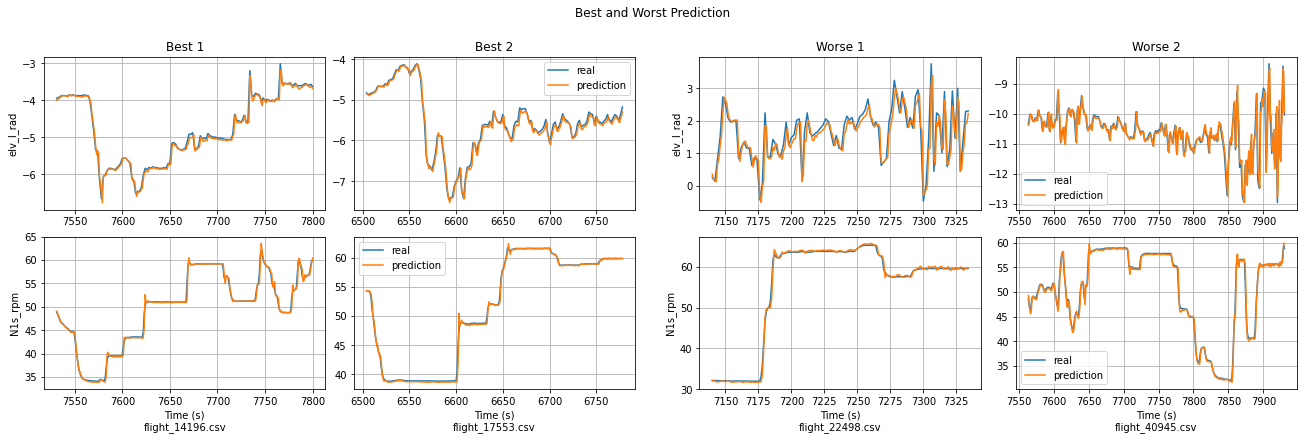

In [19]:
metric_label = ["r2_elv_l_rad"]
plot_best_and_worst(metric_label)

/tmp/ipykernel_104864/4126840474.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


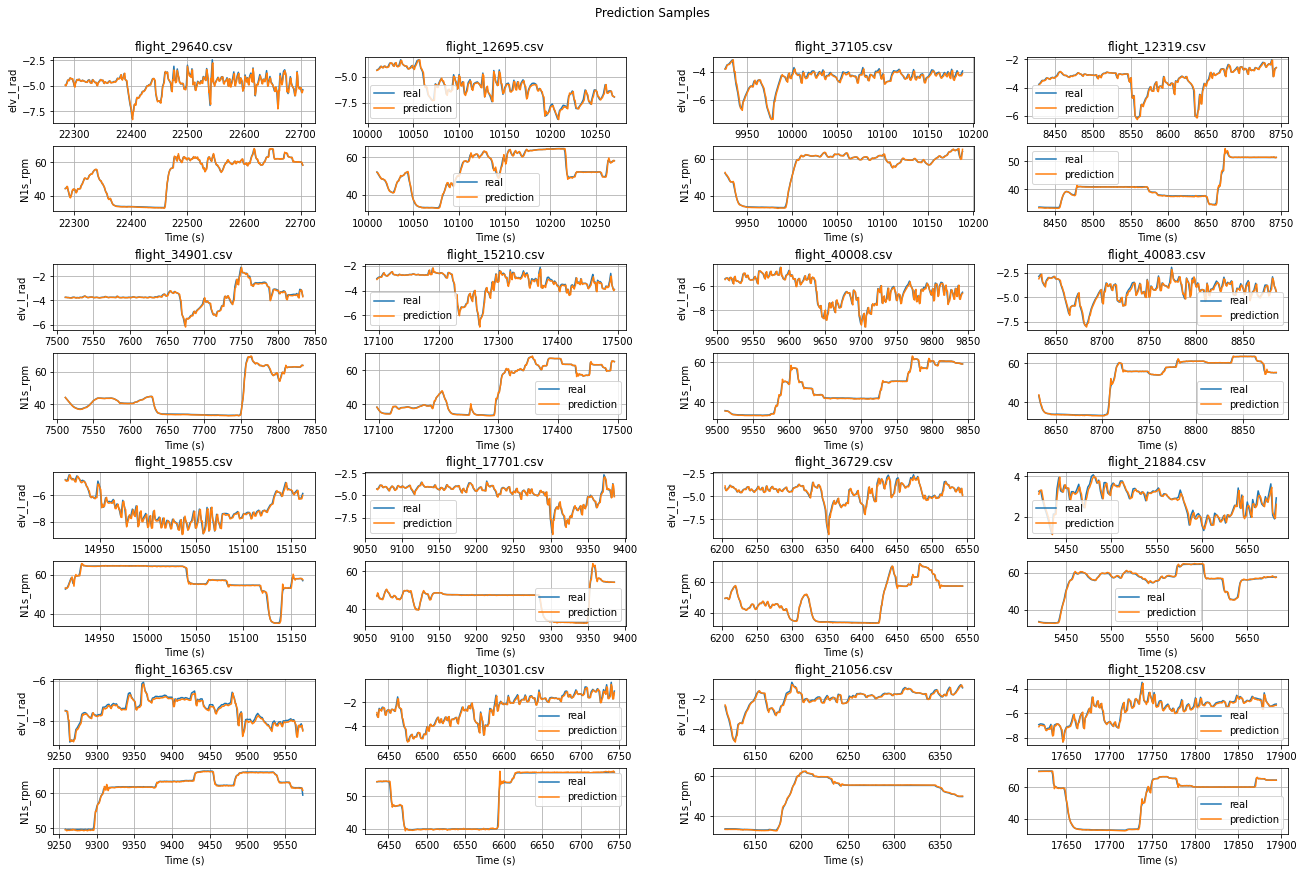

In [20]:
row = 4
col = 4

n = row*col
filelist = list(r2_df.sample(n).iloc[:, 0])

PlotManyPredictions(filelist, r=row)

In [21]:
model.summary()


Model: "residual_wrapper"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1, 2)              1502      
Total params: 1,502
Trainable params: 1,502
Non-trainable params: 0
_________________________________________________________________
